In [72]:
import lightning as L 
import pandas as pd 
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import random
import os
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from torchtext.vocab import build_vocab_from_iterator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ofekglik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
if torch.backends.mps.is_built():
    device = torch.device('mps')

In [3]:
device

device(type='mps')

# Setting the Random Seed

In [4]:
SEED = 43
def random_seed(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

random_seed(SEED)

# Loading the Data

In [5]:
train = pd.read_csv('train.csv', encoding='ISO-8859-1')

In [6]:
train.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [7]:
test = pd.read_csv('test.csv', encoding='ISO-8859-1')

In [8]:
test.head()

,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668


In [9]:
product_descriptions = pd.read_csv('product_descriptions.csv', encoding='ISO-8859-1')

In [10]:
product_descriptions.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [11]:
sample_submission = pd.read_csv('sample_submission.csv', encoding='ISO-8859-1')

In [12]:
sample_submission.head()

,id,relevance
0,1,1
1,4,1
2,5,1
3,6,1
4,7,1


# Merging the Data with the Product Descriptions and the Solution File
## taking only the relevant data from the solution file and merging it with the test data

In [13]:
train_with_descriptions = pd.merge(train, product_descriptions, on='product_uid')
test_with_descriptions = pd.merge(test, product_descriptions, on='product_uid')

In [16]:
solution = pd.read_csv('solution.csv', encoding='ISO-8859-1')
solution.head()

,id,relevance,Usage
0,1,-1.00,Ignored
1,4,2.33,Public
2,5,2.33,Private
3,6,2.67,Private
4,7,2.00,Public


In [18]:
test_with_descriptions = pd.merge(test_with_descriptions, solution, on='id')

In [30]:
test_with_descriptions = test_with_descriptions[test_with_descriptions['relevance'] > 0]

# Exploratory Data Analysis (EDA)

In [31]:
print(f'Train dataset shape: {train_with_descriptions.shape}')
print(f'Test dataset shape: {test_with_descriptions.shape}')

Train dataset shape: (74067, 6)
Test dataset shape: (112067, 7)


In [32]:
train_with_descriptions.sample(1).iloc[0]

id                                                                159743
product_uid                                                       161669
product_title          Masterbuilt 10 Qt. Propane Gas Outdoor Fryer a...
search_term                                         propane turkey fryer
relevance                                                            3.0
product_description    This liquefied propane (LP) turkey fryer and g...
Name: 52612, dtype: object

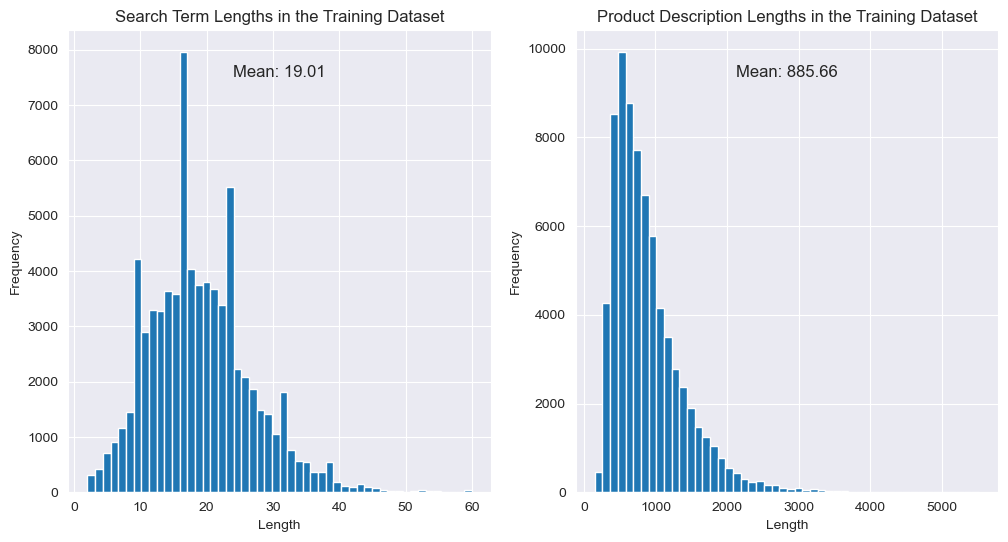

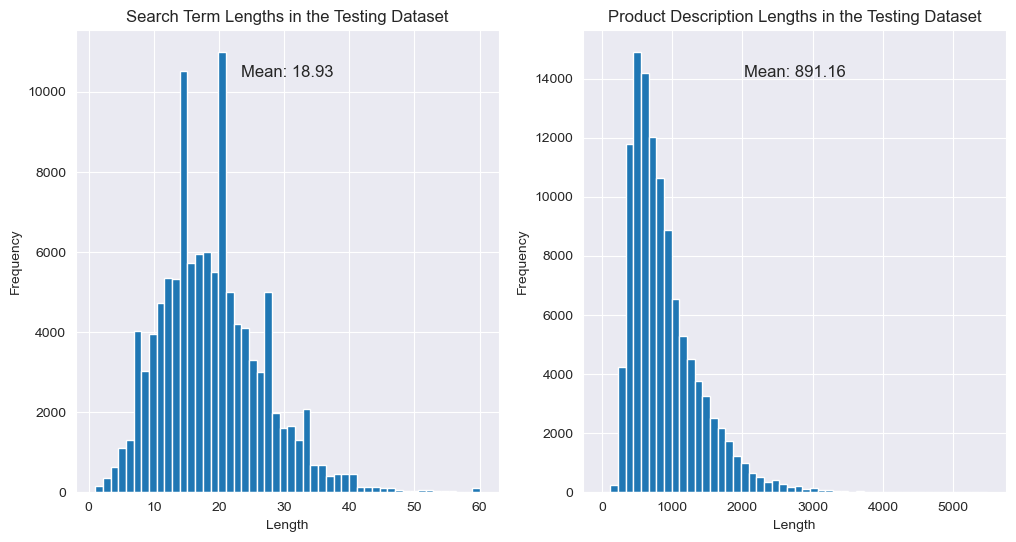

In [33]:
def plot_lengths_distribution(data, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    search_term_lengths = data['search_term'].apply(len)
    product_description_lengths = data['product_description'].apply(len)
    
    axes[0].hist(search_term_lengths, bins=50)
    axes[0].set_title(f'Search Term Lengths in the {title} Dataset')
    axes[0].set_xlabel('Length')
    axes[0].set_ylabel('Frequency')
    axes[0].annotate(f'Mean: {search_term_lengths.mean():.2f}', xy=(0.5, 0.9), xycoords='axes fraction', ha='center', fontsize=12)
    
    axes[1].hist(product_description_lengths, bins=50)
    axes[1].set_title(f'Product Description Lengths in the {title} Dataset')
    axes[1].set_xlabel('Length')
    axes[1].set_ylabel('Frequency')
    axes[1].annotate(f'Mean: {product_description_lengths.mean():.2f}', xy=(0.5, 0.9), xycoords='axes fraction', ha='center', fontsize=12)
    
    plt.show()

plot_lengths_distribution(train_with_descriptions, 'Training')
plot_lengths_distribution(test_with_descriptions, 'Testing')

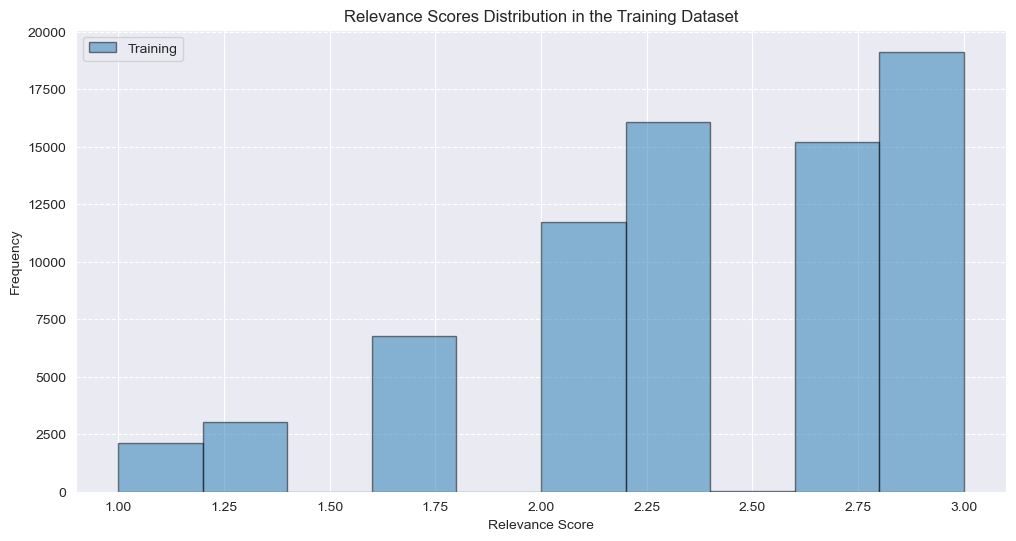

In [36]:
def plot_relevance_distribution(data, title):
    plt.figure(figsize=(12, 6))

    plt.hist(data['relevance'], alpha=0.5, label=f'{title}', edgecolor='black')
    plt.title(f'Relevance Scores Distribution in the {title} Dataset')
    plt.xlabel('Relevance Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y', linestyle='--')
    plt.show()

plot_relevance_distribution(train_with_descriptions, 'Training')

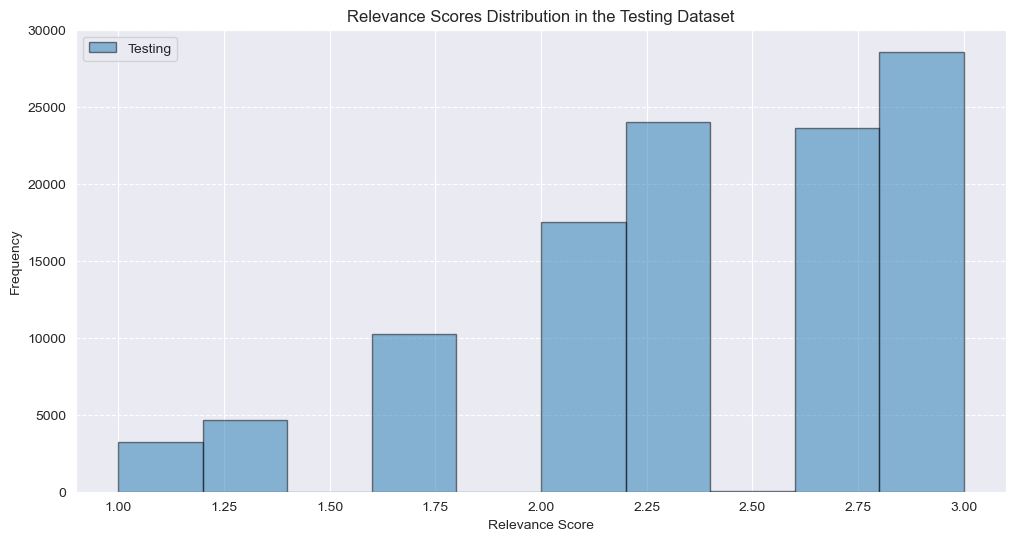

In [37]:
plot_relevance_distribution(test_with_descriptions, 'Testing')

# Preprocessing the Data

In [38]:
ENGLISH_STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word.lower() not in ENGLISH_STOPWORDS])
    return text


In [39]:
train_with_descriptions['search_term'] = train_with_descriptions['search_term'].apply(remove_stopwords)
train_with_descriptions['product_description'] = train_with_descriptions['product_description'].apply(remove_stopwords)
test_with_descriptions['search_term'] = test_with_descriptions['search_term'].apply(remove_stopwords)
test_with_descriptions['product_description'] = test_with_descriptions['product_description'].apply(remove_stopwords)

In [40]:
train_data, val_data = train_test_split(train_with_descriptions, test_size=0.2, random_state=SEED)

In [41]:
train_data.head(3)

,id,product_uid,product_title,search_term,relevance,product_description
26040,79859,123283,RIDGID 7 in. Continuous Diamond Blade,wet tile saw blade,2.33,RIDGID diamond blade made Hi-Grade diamond pow...
72488,216916,202725,Lyons Industries Style CB Top Mount Acrylic 33...,33 x19 acrylic white double bowl sink,3.00,Lyons Industries high-gloss acrylic sinks manu...
36043,110187,135931,Arlington Industries 12-1/2 in. x 11-1/4 in. P...,siding blocks,2.33,ARLINGTON INDUSTRIES INC 12-1/2 in. x 11-1/4 i...


In [42]:
train_data.shape, val_data.shape

((59253, 6), (14814, 6))

# Building a Character-Level Siamese Network

In [43]:
def yield_tokens(data_iter):
    for text in data_iter:
        yield list(text)

all_texts = pd.concat([
    train_with_descriptions['search_term'], 
    train_with_descriptions['product_description'],
])

vocab = build_vocab_from_iterator(yield_tokens(all_texts), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])  


def encode_sequence(sequence, vocab):
    return [vocab[token] for token in list(sequence)]

test_with_descriptions['search_term_encoded'] = test_with_descriptions['search_term'].apply(lambda x: encode_sequence(x, vocab))
test_with_descriptions['product_description_encoded'] = test_with_descriptions['product_description'].apply(lambda x: encode_sequence(x, vocab))

train_data['search_term_encoded'] = train_data['search_term'].apply(lambda x: encode_sequence(x, vocab))
train_data['product_description_encoded'] = train_data['product_description'].apply(lambda x: encode_sequence(x, vocab))
val_data['search_term_encoded'] = val_data['search_term'].apply(lambda x: encode_sequence(x, vocab))
val_data['product_description_encoded'] = val_data['product_description'].apply(lambda x: encode_sequence(x, vocab))

In [44]:
train_data[['search_term_encoded', 'product_description_encoded']].head()

,search_term_encoded,product_description_encoded
26040,"[22, 2, 4, 1, 4, 3, 10, 2, 1, 6, 5, 22, 1, 20,...","[43, 49, 34, 55, 49, 34, 1, 12, 3, 5, 15, 9, 8..."
72488,"[38, 38, 1, 30, 27, 64, 1, 5, 11, 7, 19, 10, 3...","[40, 19, 9, 8, 6, 1, 49, 8, 12, 13, 6, 4, 7, 3..."
36043,"[6, 3, 12, 3, 8, 16, 1, 20, 10, 9, 11, 25, 6]","[35, 43, 40, 49, 60, 55, 42, 62, 60, 1, 49, 60..."
29406,"[23, 5, 11, 13, 13, 15, 1, 20, 5, 16]","[32, 7, 5, 4, 4, 1, 43, 2, 4, 5, 3, 10, 1, 31,..."
50856,"[10, 5, 7, 16, 2, 1, 5, 7, 2, 5, 1, 7, 13, 16, 6]","[31, 4, 2, 14, 1, 11, 9, 10, 10, 2, 11, 4, 3, ..."


In [45]:
test_with_descriptions[['search_term_encoded', 'product_description_encoded']].head()

,search_term_encoded,product_description_encoded
1,"[15, 2, 4, 5, 10, 1, 10, 1, 20, 7, 5, 11, 25, ...","[5, 8, 16, 10, 2, 6, 1, 15, 5, 25, 2, 1, 59, 9..."
2,"[6, 3, 15, 14, 6, 9, 8, 1, 6, 25, 13, 1, 5, 20...","[5, 8, 16, 10, 2, 6, 1, 15, 5, 25, 2, 1, 59, 9..."
3,"[6, 3, 15, 14, 6, 9, 8, 1, 6, 4, 7, 9, 8, 16, ...","[5, 8, 16, 10, 2, 6, 1, 15, 5, 25, 2, 1, 59, 9..."
4,"[6, 3, 15, 14, 6, 9, 8, 1, 6, 4, 7, 9, 8, 16, ...","[5, 8, 16, 10, 2, 6, 1, 15, 5, 25, 2, 1, 59, 9..."
6,"[20, 5, 4, 17, 1, 6, 17, 9, 22, 2, 7, 1, 25, 3...","[29, 10, 5, 6, 6, 3, 11, 1, 5, 7, 11, 17, 3, 4..."


# Building the Dataset and Dataloader

In [46]:
class CharRelevanceDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.search_terms = list(df['search_term_encoded'])
        self.descriptions = list(df['product_description_encoded'])
        self.relevances = df['relevance'].values
    def __len__(self):
        return len(self.search_terms)

    def __getitem__(self, idx):
        search_term = torch.tensor(self.search_terms[idx], dtype=torch.long)
        description = torch.tensor(self.descriptions[idx], dtype=torch.long)
        relevance = torch.tensor(self.relevances[idx], dtype=torch.float32)
        return search_term, description, relevance
        

In [47]:
train_dataset = CharRelevanceDataset(train_data)
val_dataset = CharRelevanceDataset(val_data)
test_dataset = CharRelevanceDataset(test_with_descriptions)

In [48]:
def collate_fn(batch):
    search_terms = pad_sequence([item[0] for item in batch], batch_first=True, padding_value=0)
    descriptions = pad_sequence([item[1] for item in batch], batch_first=True, padding_value=0)
    relevances = torch.tensor([item[2] for item in batch], dtype=torch.float32)
    return search_terms, descriptions, relevances

In [49]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [51]:
for batch in test_dataloader:
    search_term, description, relevance = batch
    print(search_term, description, relevance)
    print(search_term.shape, description.shape, relevance.shape)
    break

tensor([[15,  2,  4,  ...,  0,  0,  0],
        [ 6,  3, 15,  ...,  0,  0,  0],
        [ 6,  3, 15,  ...,  0,  0,  0],
        ...,
        [ 6,  4,  2,  ...,  0,  0,  0],
        [50, 18,  4,  ...,  0,  0,  0],
        [20,  5, 15,  ...,  0,  0,  0]]) tensor([[ 5,  8, 16,  ...,  0,  0,  0],
        [ 5,  8, 16,  ...,  0,  0,  0],
        [ 5,  8, 16,  ...,  0,  0,  0],
        ...,
        [43, 13, 20,  ...,  0,  0,  0],
        [48,  5, 11,  ...,  0,  0,  0],
        [48,  5, 11,  ...,  0,  0,  0]]) tensor([2.3300, 2.3300, 2.6700, 2.0000, 2.6700, 2.0000, 3.0000, 2.0000, 2.6700,
        3.0000, 2.3300, 2.0000, 2.0000, 1.0000, 2.0000, 2.6700, 3.0000, 3.0000,
        2.6700, 2.6700, 2.3300, 2.6700, 2.0000, 3.0000, 3.0000, 1.0000, 1.6700,
        2.0000, 2.3300, 1.3300, 2.3300, 3.0000])
torch.Size([32, 33]) torch.Size([32, 1859]) torch.Size([32])


# Building a Character-Level Siamese Network

In [76]:
class Siamese_Character_Model(L.LightningModule):
    def __init__(self, vocab_size=len(vocab)+1, embedding_dim=1, hidden_dim=64):
        super().__init__()
        self.embedding1 = nn.Embedding(vocab_size, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=3)
        self.dropout1 = nn.Dropout(0.3)
        self.bn11 = nn.BatchNorm1d(hidden_dim)
        self.bn21 = nn.BatchNorm1d(128)
        self.fc11 = nn.Linear(hidden_dim, 128)
        self.fc21 = nn.Linear(128, 32)
        
        
        
        self.embedding2 = nn.Embedding(vocab_size, embedding_dim)
        self.lstm2 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=3)
        self.dropout2 = nn.Dropout(0.3)
        self.bn12 = nn.BatchNorm1d(hidden_dim)
        self.bn22 = nn.BatchNorm1d(128)
        self.fc12 = nn.Linear(hidden_dim, 128)
        self.fc22 = nn.Linear(128, 32)
        
        self.out = nn.Linear(32, 1)
        
    def first_forward(self, x):
        x = self.embedding1(x)
        _, (h_n, _) = self.lstm1(x)
        h_n_last = h_n[-1,:,:]
        x = self.bn11(h_n_last)
        x = self.fc11(x)
        x = self.bn21(x)
        x = self.dropout1(x)
        x = self.fc21(x)
        return x
    
    def second_forward(self, x):
        x = self.embedding2(x)
        _, (h_n, _) = self.lstm2(x)
        h_n_last = h_n[-1,:,:]
        x = self.bn12(h_n_last)
        x = self.fc12(x)
        x = self.bn22(x)
        x = self.dropout2(x)
        x = self.fc22(x)
        return x

    def forward(self, x1, x2):
        x1 = self.first_forward(x1)
        x2 = self.second_forward(x2)
        difference = torch.abs(x1 - x2)
        output = self.out(difference)
        return output
    
    def training_step(self, batch, batch_idx):
        x1, x2, y = batch
        y_pred = self(x1, x2).squeeze()
        mse_loss = nn.MSELoss()(y.float(), y_pred)
        rmse = torch.sqrt(mse_loss)
        loss = nn.L1Loss()(y.float(), y_pred)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_rmse', rmse, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x1, x2, y = batch
        y_pred = self(x1, x2).squeeze()
        mse_loss = nn.MSELoss()(y.float(), y_pred)
        rmse = torch.sqrt(mse_loss)
        loss = nn.L1Loss()(y.float(), y_pred)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_rmse', rmse, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)
        
                
        

In [77]:
def train_model(model, model_class, train_dataloader, val_dataloader, folder_name, model_name, max_epochs=10, patience=5):
    checkpoint_callback = ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min')
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=patience, mode='min', verbose=True)
    logger = TensorBoardLogger(folder_name, name=model_name)
    trainer = L.Trainer(max_epochs=max_epochs, callbacks=[checkpoint_callback, early_stopping_callback], logger=logger)
    trainer.fit(model, train_dataloader, val_dataloader)
    model = model_class.load_from_checkpoint(checkpoint_callback.best_model_path)
    return model

In [78]:
first_model = train_model(Siamese_Character_Model(), Siamese_Character_Model,train_dataloader, val_dataloader, 'final_siamese_char_logs', 'final_siamese_char_model', max_epochs=15, patience=5)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: final_siamese_char_logs/final_siamese_char_model

   | Name       | Type        | Params
--------------------------------------------
0  | embedding1 | Embedding   | 96    
1  | lstm1      | LSTM        | 83.7 K
2  | dropout1   | Dropout     | 0     
3  | bn11       | BatchNorm1d | 128   
4  | bn21       | BatchNorm1d | 256   
5  | fc11       | Linear      | 8.3 K 
6  | fc21       | Linear      | 4.1 K 
7  | embedding2 | Embedding   | 96    
8  | lstm2      | LSTM        | 83.7 K
9  | dropout2   | Dropout     | 0     
10 | bn12       | BatchNorm1d | 128   
11 | bn22       | BatchNorm1d | 256   
12 | fc12       | Linear      | 8.3 K 
13 | fc22       | Linear      | 4.1 K 
14 | out        | Linear      | 33    
--------------------------------------------
193 K     Trainable params
0         Non-trainable params
193 

Sanity Checking: 0it [00:00, ?it/s]

/Users/ofekglik/miniconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/ofekglik/miniconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:02, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.465


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.459


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.454


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.448


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.446


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.442
`Trainer.fit` stopped: `max_epochs=15` reached.


In [79]:
first_model

Siamese_Character_Model(
  (embedding1): Embedding(96, 1)
  (lstm1): LSTM(1, 64, num_layers=3, batch_first=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (bn11): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn21): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc11): Linear(in_features=64, out_features=128, bias=True)
  (fc21): Linear(in_features=128, out_features=32, bias=True)
  (embedding2): Embedding(96, 1)
  (lstm2): LSTM(1, 64, num_layers=3, batch_first=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (bn12): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn22): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc12): Linear(in_features=64, out_features=128, bias=True)
  (fc22): Linear(in_features=128, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [80]:
def create_results_df(model, loader, vocab):
    model.eval()
    results = []
    unk_token = '<unk>'
    
    for batch in loader:
        search_term, description, relevance = (item.to(device) for item in batch)        
        with torch.no_grad():
            y_pred = model(search_term, description).squeeze()
        search_term_text = [''.join([vocab.lookup_token(st) for st in seq if vocab.lookup_token(st) != unk_token])
                            for seq in search_term.cpu()]
        description_text = [''.join([vocab.lookup_token(ds) for ds in seq if vocab.lookup_token(ds) != unk_token])
                             for seq in description.cpu()]
        y_pred = y_pred.cpu().numpy()
        relevance = relevance.cpu().numpy()
        results.extend(zip(search_term_text, description_text, y_pred, relevance))
        break
        
    df = pd.DataFrame(results, columns=['search_term', 'description', 'predicted_relevance', 'true_relevance'])
    
    return df

In [81]:
results = create_results_df(first_model, val_dataloader, vocab)

In [82]:
results.head()

,search_term,description,predicted_relevance,true_relevance
0,adhesive slide strip,Get organized Self-Adhesive Single Hook! small...,2.404911,3.00
1,fraiming nailer electric,NR83AA3 3-1/4 in. paper collated framing naile...,2.404919,2.33
2,soild 6 panel interior door,Builder's Choice 6-Panel Clear Pine doors made...,2.404909,2.33
3,column post,Add elegance sophistication porch deck. Porch ...,2.404924,3.00
4,Kitchen aid wall ovens,30 in. Combination Wall Oven Even-Heat True Co...,2.436931,3.00


In [89]:
def calc_metrics_on_loader(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    for batch in loader:
        search_term, description, relevance = (item.to(device) for item in batch)
        with torch.no_grad():
            y_pred.extend(model(search_term, description).squeeze().cpu().numpy())
            y_true.extend(relevance.cpu().numpy())
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

In [90]:
val_first_metrics = calc_metrics_on_loader(first_model, val_dataloader)
print(f"Validation Metrics: {val_first_metrics}")
test_first_metrics = calc_metrics_on_loader(first_model, test_dataloader)
print(f"Test Metrics: {test_first_metrics}")
train_first_metrics = calc_metrics_on_loader(first_model, train_dataloader)
print(f"Train Metrics: {train_first_metrics}")

Validation Metrics: {'MAE': 0.4421565, 'MSE': 0.29288644, 'RMSE': 0.54118985}
Test Metrics: {'MAE': 0.44413006, 'MSE': 0.2980659, 'RMSE': 0.5459541}
Train Metrics: {'MAE': 0.44131956, 'MSE': 0.2907081, 'RMSE': 0.53917354}


# Building a naive baseline model using character-level embeddings

In [92]:
data = train_with_descriptions.copy()
data['combined_text'] = data['search_term'] + ' ' + data['product_description']
vectorizer = CountVectorizer(analyzer='char')
X = vectorizer.fit_transform(data['combined_text'])
y = data['relevance'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)


test_data = test_with_descriptions.copy()
test_data['combined_text'] = test_data['search_term'] + ' ' + test_data['product_description']
X_test_data = vectorizer.transform(test_data['combined_text'])
y_test_data = test_data['relevance'].values


models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=SEED),
    "Ridge Regression": Ridge(random_state=SEED),
    "Lasso Regression": Lasso(random_state=SEED)
}

results = {"Model": [], "MAE_train": [], "RMSE_train": [], "MAE_val": [], "RMSE_val": [], "MAE_test": [], "RMSE_test": []}

for name, model in models.items():
    model.fit(X_train, y_train)
    
    y_pred_val = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_val)
    rmse = np.sqrt(mse)  
    mae = mean_absolute_error(y_test, y_pred_val)
    results["Model"].append(name)
    results["MAE_val"].append(mae)
    results["RMSE_val"].append(rmse)
    
    y_pred_train = model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred_train)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_train, y_pred_train)
    results["MAE_train"].append(mae)
    results["RMSE_train"].append(rmse)
    
    y_pred_test = model.predict(X_test_data)
    mse = mean_squared_error(y_test_data, y_pred_test)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_data, y_pred_test)
    results["MAE_test"].append(mae)
    results["RMSE_test"].append(rmse)
    

results_df = pd.DataFrame(results)

In [93]:
results_df

,Model,MAE_train,RMSE_train,MAE_val,RMSE_val,MAE_test,RMSE_test
0,Linear Regression,0.435078,0.531917,0.435540,0.532581,0.436715,0.534149
1,Random Forest,0.166681,0.208256,0.435559,0.535007,0.447854,0.548507
2,Ridge Regression,0.435078,0.531917,0.435541,0.532582,0.436715,0.534149
3,Lasso Regression,0.437560,0.533699,0.438144,0.534521,0.438521,0.535156


In [94]:
train_data = train_with_descriptions.copy()
test_data = test_with_descriptions.copy()

train_data['search_term'] = train_data['search_term'].apply(nltk.word_tokenize)
train_data['product_description'] = train_data['product_description'].apply(nltk.word_tokenize)
test_data['search_term'] = test_data['search_term'].apply(nltk.word_tokenize)
test_data['product_description'] = test_data['product_description'].apply(nltk.word_tokenize)


In [95]:
train_data.head()

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,"[angle, bracket]",3.00,"[angles, make, joints, stronger, ,, also, prov..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,"[l, bracket]",2.50,"[angles, make, joints, stronger, ,, also, prov..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,[deck],3.00,"[BEHR, Premium, Textured, DECKOVER, innovative..."
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,"[rain, shower, head]",2.33,"[Update, bathroom, Delta, Vero, Single-Handle,..."
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,"[shower, faucet]",2.67,"[Update, bathroom, Delta, Vero, Single-Handle,..."


# Building a Word-Level Siamese Network

In [96]:
all_texts = pd.concat([train_data['search_term'], train_data['product_description']])
vocab = build_vocab_from_iterator(all_texts, specials=['<unk>'])    
vocab.set_default_index(vocab['<unk>']) 

In [97]:
w2v = Word2Vec(sentences=all_texts, vector_size=300, window=5, min_count=1, workers=4)

In [98]:
w2v.train(all_texts, total_examples=w2v.corpus_count, epochs=10)

(74037035, 82690900)

In [99]:
w2v.wv['the']

array([ 0.08294488, -0.92514753, -0.23872155,  0.4760331 , -0.5960319 ,
        1.1667905 ,  0.5512598 , -0.01363624,  0.9837    ,  0.11547148,
        0.01882452,  0.09160011, -0.5534414 ,  0.73873615,  0.5256696 ,
       -0.6796916 ,  0.16067411, -0.6061573 , -0.5280299 ,  0.5645555 ,
        0.11556417,  0.55822027, -0.17886089, -0.18772732,  0.16393551,
       -0.44822982, -0.13021976, -0.20007488,  0.7580937 , -0.12643698,
       -0.603324  , -0.01677587, -0.4790335 , -0.57774293,  1.4061034 ,
        0.02566773,  0.82700723, -0.612441  , -0.37240058, -0.8590856 ,
       -1.5671015 , -0.47851297,  0.46320194,  0.19010516, -0.60953945,
       -0.7995232 , -0.49746555,  0.7921353 ,  0.2025561 ,  0.07288355,
       -0.85612386, -0.23564957, -0.24933268, -0.47748503,  0.7380532 ,
        0.3984918 , -0.13980947, -0.82321376,  1.737431  , -0.63837624,
        0.82085955, -0.04609111, -0.22527966,  1.2436421 , -0.16676855,
        1.3127522 , -0.29770744, -0.8812623 , -0.8548179 ,  1.71

In [106]:
w2v.wv.most_similar('angle')

[('angles', 0.4536053538322449),
 ('detents', 0.42463356256484985),
 ('drillHome', 0.41877609491348267),
 ('degree', 0.40135326981544495),
 ('wallHandheld', 0.3885921835899353),
 ('diesLimited', 0.38656216859817505),
 ('jobComfort', 0.3859924376010895),
 ('leftPlumb', 0.3841972053050995),
 ('offset', 0.3821152448654175),
 ('left', 0.38055774569511414)]

In [107]:
def embed_sequence(sequence, w2v):
    return [w2v.wv[word] for word in sequence if word in w2v.wv.key_to_index]

train_data['search_term_embedded'] = train_data['search_term'].apply(lambda x: embed_sequence(x, w2v))
train_data['product_description_embedded'] = train_data['product_description'].apply(lambda x: embed_sequence(x, w2v))
test_data['search_term_embedded'] = test_data['search_term'].apply(lambda x: embed_sequence(x, w2v))
test_data['product_description_embedded'] = test_data['product_description'].apply(lambda x: embed_sequence(x, w2v))

In [108]:
train_data[['search_term_embedded', 'product_description_embedded']].head()

,search_term_embedded,product_description_embedded
0,"[[1.5084994, -0.5510181, 0.02883155, 1.1298926...","[[0.8002216, -1.2167457, 2.05972, -0.2625372, ..."
1,"[[0.5459661, 0.42498568, 0.2360346, 0.47907296...","[[0.8002216, -1.2167457, 2.05972, -0.2625372, ..."
2,"[[-0.23774794, -1.8844466, -3.196015, 0.030547...","[[0.14396618, 1.6337265, -1.8585943, -0.977123..."
3,"[[-1.3160219, -4.698496, 0.26284897, 0.7581072...","[[1.3695577, -0.7826093, 0.5031104, 0.4819416,..."
4,"[[1.6052382, -1.708878, -4.263003, 0.2810915, ...","[[1.3695577, -0.7826093, 0.5031104, 0.4819416,..."


In [109]:
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=SEED)

In [110]:
print(f"Train dataset shape: {train_data.shape}")
print(f"Validation dataset shape: {val_data.shape}")

Train dataset shape: (59253, 8)
Validation dataset shape: (14814, 8)


In [111]:
class WordRelevanceDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.search_terms = list(df['search_term_embedded'])
        self.descriptions = list(df['product_description_embedded'])
        self.relevances = df['relevance'].values
    def __len__(self):
        return len(self.search_terms)

    def __getitem__(self, idx):
        search_term = torch.tensor(self.search_terms[idx], dtype=torch.float32)
        description = torch.tensor(self.descriptions[idx], dtype=torch.float32)
        relevance = torch.tensor(self.relevances[idx], dtype=torch.float32)
        return search_term, description, relevance, self.df['search_term'].iloc[idx], self.df['product_description'].iloc[idx]

In [112]:
train_words_dataset = WordRelevanceDataset(train_data)
val_words_dataset = WordRelevanceDataset(val_data)
test_words_dataset = WordRelevanceDataset(test_data)

In [119]:
def collate_fn(batch):
    search_terms, descriptions, relevances, text1, text2 = zip(*batch)
    
    search_terms_padded = pad_sequence([torch.tensor(seq, dtype=torch.float32) if len(seq) > 0 else torch.zeros(1, 300) for seq in search_terms], batch_first=True, padding_value=0.0)
    descriptions_padded = pad_sequence([torch.tensor(seq, dtype=torch.float32) if len(seq) > 0 else torch.zeros(1, 300) for seq in descriptions], batch_first=True, padding_value=0.0)
    
    relevances = torch.tensor(relevances, dtype=torch.float32)
    
    return search_terms_padded, descriptions_padded, relevances, text1, text2

In [120]:
train_words_dataloader = DataLoader(train_words_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_words_dataloader = DataLoader(val_words_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_words_dataloader = DataLoader(test_words_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [125]:
class Siamese_Words_Model(L.LightningModule):
    def __init__(self, embedding_dim=300, hidden_dim=64):
        super().__init__()
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=3)
        self.dropout1 = nn.Dropout(0.3)
        self.bn11 = nn.BatchNorm1d(hidden_dim)
        self.bn21 = nn.BatchNorm1d(128)
        self.fc11 = nn.Linear(hidden_dim, 128)
        self.fc21 = nn.Linear(128, 32)
        
        self.lstm2 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=3)
        self.dropout2 = nn.Dropout(0.3)
        self.bn12 = nn.BatchNorm1d(hidden_dim)
        self.bn22 = nn.BatchNorm1d(128)
        self.fc12 = nn.Linear(hidden_dim, 128)
        self.fc22 = nn.Linear(128, 32)
        
        self.out = nn.Linear(32, 1)
        
    def first_forward(self, x):
        _, (h_n, _) = self.lstm1(x)
        h_n_last = h_n[-1,:,:]
        x = self.bn11(h_n_last)
        x = self.fc11(x)
        x = self.bn21(x)
        x = self.dropout1(x)
        x = self.fc21(x)
        return x
    
    def second_forward(self, x):
        _, (h_n, _) = self.lstm2(x)
        h_n_last = h_n[-1,:,:]
        x = self.bn12(h_n_last)
        x = self.fc12(x)
        x = self.bn22(x)
        x = self.dropout2(x)
        x = self.fc22(x)
        return x

    def forward(self, x1, x2):
        x1 = self.first_forward(x1)
        x2 = self.second_forward(x2)
        difference = torch.abs(x1 - x2)
        output = self.out(difference)
        return output
    
    def training_step(self, batch, batch_idx):
        x1, x2, y, text1, text2 = batch
        y_pred = self(x1, x2).squeeze()
        mse_loss = nn.MSELoss()(y.float(), y_pred)
        rmse = torch.sqrt(mse_loss)
        loss = nn.L1Loss()(y.float(), y_pred)
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_rmse', rmse, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x1, x2, y, text1, text2 = batch
        y_pred = self(x1, x2).squeeze()
        mse_loss = nn.MSELoss()(y.float(), y_pred)
        rmse = torch.sqrt(mse_loss)
        loss = nn.L1Loss()(y.float(), y_pred)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_rmse', rmse, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)
        
                
        

In [127]:
second_model = train_model(Siamese_Words_Model(), Siamese_Words_Model,train_words_dataloader, val_words_dataloader, 'final_siamese_word_logs', 'final_siamese_word_model', max_epochs=15, patience=5)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name     | Type        | Params
------------------------------------------
0  | lstm1    | LSTM        | 160 K 
1  | dropout1 | Dropout     | 0     
2  | bn11     | BatchNorm1d | 128   
3  | bn21     | BatchNorm1d | 256   
4  | fc11     | Linear      | 8.3 K 
5  | fc21     | Linear      | 4.1 K 
6  | lstm2    | LSTM        | 160 K 
7  | dropout2 | Dropout     | 0     
8  | bn12     | BatchNorm1d | 128   
9  | bn22     | BatchNorm1d | 256   
10 | fc12     | Linear      | 8.3 K 
11 | fc22     | Linear      | 4.1 K 
12 | out      | Linear      | 33    
------------------------------------------
346 K     Trainable params
0         Non-trainable params
346 K     Total params
1.385     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/ofekglik/miniconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/var/folders/yv/5v33gcn53hzf9937q1lnv1040000gn/T/ipykernel_94067/502060605.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  search_terms_padded = pad_sequence([torch.tensor(seq, dtype=torch.float32) if len(seq) > 0 else torch.zeros(1, 300) for seq in search_terms], batch_first=True, padding_value=0.0)
/var/folders/yv/5v33gcn53hzf9937q1lnv1040000gn/T/ipykernel_94067/502060605.py:7: UserWarning: To copy construct from a tensor, it is recom

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.452


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.443


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.443


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.437


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.431


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.429


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.427


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.419


Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [128]:
second_model

Siamese_Words_Model(
  (lstm1): LSTM(300, 64, num_layers=3, batch_first=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (bn11): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn21): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc11): Linear(in_features=64, out_features=128, bias=True)
  (fc21): Linear(in_features=128, out_features=32, bias=True)
  (lstm2): LSTM(300, 64, num_layers=3, batch_first=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (bn12): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn22): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc12): Linear(in_features=64, out_features=128, bias=True)
  (fc22): Linear(in_features=128, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [129]:
results = {
    'search_term': [],
    'description': [],
    'predicted_relevance': [],
    'true_relevance': []
}

for batch in val_words_dataloader:
    search_term, description, relevance, text_search_term, text_description = batch
    text_search_term = [' '.join(seq) for seq in text_search_term]
    text_description = [' '.join(seq) for seq in text_description]
    search_term = search_term.to(device)
    description = description.to(device)
    relevance = relevance.to(device)
    relevance = relevance.cpu().numpy()

    with torch.no_grad():
        y_pred = second_model(search_term, description).squeeze()

    y_pred = y_pred.cpu().numpy()

    results['search_term'].extend(text_search_term)
    results['description'].extend(text_description)
    results['predicted_relevance'].extend(y_pred)
    results['true_relevance'].extend(relevance)
    break  
results_df = pd.DataFrame(results)


/var/folders/yv/5v33gcn53hzf9937q1lnv1040000gn/T/ipykernel_94067/502060605.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  search_terms_padded = pad_sequence([torch.tensor(seq, dtype=torch.float32) if len(seq) > 0 else torch.zeros(1, 300) for seq in search_terms], batch_first=True, padding_value=0.0)
/var/folders/yv/5v33gcn53hzf9937q1lnv1040000gn/T/ipykernel_94067/502060605.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  descriptions_padded = pad_sequence([torch.tensor(seq, dtype=torch.float32) if len(seq) > 0 else torch.zeros(1, 300) for seq in descriptions], batch_first=True, padding_value=0.0)


In [130]:
results_df

,search_term,description,predicted_relevance,true_relevance
0,adhesive slide strip,Get organized Self-Adhesive Single Hook ! smal...,2.398154,3.00
1,fraiming nailer electric,NR83AA3 3-1/4 in . paper collated framing nail...,2.625624,2.33
2,soild 6 panel interior door,Builder 's Choice 6-Panel Clear Pine doors mad...,2.327825,2.33
3,column post,Add elegance sophistication porch deck . Porch...,2.545440,3.00
4,Kitchen aid wall ovens,30 in . Combination Wall Oven Even-Heat True C...,2.735246,3.00
5,coconut fiber,"Designed artist , distinctive mat work art add...",2.292153,3.00
6,dog fence batt,Radial-Shape Select Havahart Wireless Dog Fenc...,2.268731,2.00
7,kick plates 8x30in,simple affordable way upgrade home replace old...,2.266158,2.33
8,dusk dawn motion sensoroutdoor lighting fixtures,Featuring oil rubbed bronze finish clear bevel...,2.618818,2.33
9,kitchen cabinet door pulls,Liberty Cabinet Drawer Pull Installation Templ...,2.752829,2.67


In [136]:
def calc_metrics_on_loader_words(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    for batch in loader:
        search_term, description, relevance, text1, text2  = batch
        search_term = search_term.to(device)
        description = description.to(device)
        relevance = relevance.to(device)
        with torch.no_grad():
            y_pred.extend(model(search_term, description).squeeze().cpu().numpy())
            y_true.extend(relevance.cpu().numpy())
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

In [137]:
val_first_metrics = calc_metrics_on_loader_words(second_model, val_words_dataloader)
print(f"Validation Metrics: {val_first_metrics}")
test_first_metrics = calc_metrics_on_loader_words(second_model, test_words_dataloader)
print(f"Test Metrics: {test_first_metrics}")
train_first_metrics = calc_metrics_on_loader_words(second_model, train_words_dataloader)
print(f"Train Metrics: {train_first_metrics}")

/var/folders/yv/5v33gcn53hzf9937q1lnv1040000gn/T/ipykernel_94067/502060605.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  search_terms_padded = pad_sequence([torch.tensor(seq, dtype=torch.float32) if len(seq) > 0 else torch.zeros(1, 300) for seq in search_terms], batch_first=True, padding_value=0.0)
/var/folders/yv/5v33gcn53hzf9937q1lnv1040000gn/T/ipykernel_94067/502060605.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  descriptions_padded = pad_sequence([torch.tensor(seq, dtype=torch.float32) if len(seq) > 0 else torch.zeros(1, 300) for seq in descriptions], batch_first=True, padding_value=0.0)


Validation Metrics: {'MAE': 0.41886592, 'MSE': 0.2789937, 'RMSE': 0.52819854}


/var/folders/yv/5v33gcn53hzf9937q1lnv1040000gn/T/ipykernel_94067/502060605.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  search_terms_padded = pad_sequence([torch.tensor(seq, dtype=torch.float32) if len(seq) > 0 else torch.zeros(1, 300) for seq in search_terms], batch_first=True, padding_value=0.0)
/var/folders/yv/5v33gcn53hzf9937q1lnv1040000gn/T/ipykernel_94067/502060605.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  descriptions_padded = pad_sequence([torch.tensor(seq, dtype=torch.float32) if len(seq) > 0 else torch.zeros(1, 300) for seq in descriptions], batch_first=True, padding_value=0.0)


Test Metrics: {'MAE': 0.4381923, 'MSE': 0.302289, 'RMSE': 0.54980814}


/var/folders/yv/5v33gcn53hzf9937q1lnv1040000gn/T/ipykernel_94067/502060605.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  search_terms_padded = pad_sequence([torch.tensor(seq, dtype=torch.float32) if len(seq) > 0 else torch.zeros(1, 300) for seq in search_terms], batch_first=True, padding_value=0.0)
/var/folders/yv/5v33gcn53hzf9937q1lnv1040000gn/T/ipykernel_94067/502060605.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  descriptions_padded = pad_sequence([torch.tensor(seq, dtype=torch.float32) if len(seq) > 0 else torch.zeros(1, 300) for seq in descriptions], batch_first=True, padding_value=0.0)


Train Metrics: {'MAE': 0.4129802, 'MSE': 0.27296275, 'RMSE': 0.5224584}


In [145]:
class Siamese_Words_Model_v2(L.LightningModule):
    def __init__(self, embedding_dim=300, hidden_dim=64):
        super().__init__()
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=3, bidirectional=True)
        self.dropout1 = nn.Dropout(0.3)
        self.bn11 = nn.BatchNorm1d(hidden_dim * 2) 
        self.bn21 = nn.BatchNorm1d(128)
        self.fc11 = nn.Linear(hidden_dim * 2, 128)  
        self.fc21 = nn.Linear(128, 32)
        
        self.lstm2 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=3, bidirectional=True)
        self.dropout2 = nn.Dropout(0.3)
        self.bn12 = nn.BatchNorm1d(hidden_dim * 2)  
        self.bn22 = nn.BatchNorm1d(128)
        self.fc12 = nn.Linear(hidden_dim * 2, 128)
        self.fc22 = nn.Linear(128, 32)
        
        self.out = nn.Linear(32, 1)
        
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
        
        
    def first_forward(self, x):
        _, (h_n, _) = self.lstm1(x)
        h_n_last = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)  
        x = self.bn11(h_n_last)
        x = self.fc11(x)
        x = self.bn21(x)
        x = self.dropout1(x)
        x = self.fc21(x)
        return x
    
    def second_forward(self, x):
        _, (h_n, _) = self.lstm2(x)
        h_n_last = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1) 
        x = self.bn12(h_n_last)
        x = self.fc12(x)
        x = self.bn22(x)
        x = self.dropout2(x)
        x = self.fc22(x)
        return x

    def forward(self, x1, x2):
        x1 = self.first_forward(x1)
        x2 = self.second_forward(x2)
        difference = torch.abs(x1 - x2)
        output = self.out(difference)
        return output
    
    def training_step(self, batch, batch_idx):
        x1, x2, y, text1, text2 = batch
        y_pred = self(x1, x2).squeeze()
        mse_loss = nn.MSELoss()(y.float(), y_pred)
        rmse = torch.sqrt(mse_loss)
        loss = nn.L1Loss()(y.float(), y_pred)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_rmse', rmse, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x1, x2, y, text1, text2 = batch
        y_pred = self(x1, x2).squeeze()
        mse_loss = nn.MSELoss()(y.float(), y_pred)
        rmse = torch.sqrt(mse_loss)
        loss = nn.L1Loss()(y.float(), y_pred)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_rmse', rmse, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)


In [147]:
third_model = train_model(Siamese_Words_Model_v2(), Siamese_Words_Model_v2, train_words_dataloader, val_words_dataloader, 'final_siamese_word_logs_v2', 'final_siamese_word_model_v2', max_epochs=15, patience=5)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name     | Type        | Params
------------------------------------------
0  | lstm1    | LSTM        | 386 K 
1  | dropout1 | Dropout     | 0     
2  | bn11     | BatchNorm1d | 256   
3  | bn21     | BatchNorm1d | 256   
4  | fc11     | Linear      | 16.5 K
5  | fc21     | Linear      | 4.1 K 
6  | lstm2    | LSTM        | 386 K 
7  | dropout2 | Dropout     | 0     
8  | bn12     | BatchNorm1d | 256   
9  | bn22     | BatchNorm1d | 256   
10 | fc12     | Linear      | 16.5 K
11 | fc22     | Linear      | 4.1 K 
12 | out      | Linear      | 33    
------------------------------------------
814 K     Trainable params
0         Non-trainable params
814 K     Total params
3.258     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/ofekglik/miniconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/var/folders/yv/5v33gcn53hzf9937q1lnv1040000gn/T/ipykernel_94067/502060605.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  search_terms_padded = pad_sequence([torch.tensor(seq, dtype=torch.float32) if len(seq) > 0 else torch.zeros(1, 300) for seq in search_terms], batch_first=True, padding_value=0.0)
/var/folders/yv/5v33gcn53hzf9937q1lnv1040000gn/T/ipykernel_94067/502060605.py:7: UserWarning: To copy construct from a tensor, it is recom

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.454


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.432


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.428


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.413


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.408


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.393


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.389


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.389. Signaling Trainer to stop.


In [143]:
train_metrics = calc_metrics_on_loader_words(third_model, train_words_dataloader)
val_metrics = calc_metrics_on_loader_words(third_model, val_words_dataloader)
test_metrics = calc_metrics_on_loader_words(third_model, test_words_dataloader)

/var/folders/yv/5v33gcn53hzf9937q1lnv1040000gn/T/ipykernel_94067/502060605.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  search_terms_padded = pad_sequence([torch.tensor(seq, dtype=torch.float32) if len(seq) > 0 else torch.zeros(1, 300) for seq in search_terms], batch_first=True, padding_value=0.0)
/var/folders/yv/5v33gcn53hzf9937q1lnv1040000gn/T/ipykernel_94067/502060605.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  descriptions_padded = pad_sequence([torch.tensor(seq, dtype=torch.float32) if len(seq) > 0 else torch.zeros(1, 300) for seq in descriptions], batch_first=True, padding_value=0.0)
/var/folders/yv/5v33gcn53hzf9937q1lnv1040000gn/T/ipykernel_94067/502060605.py:6: Use

In [144]:
print(f"Train Metrics: {train_metrics}")
print(f"Validation Metrics: {val_metrics}")
print(f"Test Metrics: {test_metrics}")

Train Metrics: {'MAE': 0.30515686, 'MSE': 0.17129274, 'RMSE': 0.41387528}
Validation Metrics: {'MAE': 0.39080417, 'MSE': 0.25386646, 'RMSE': 0.50385165}
Test Metrics: {'MAE': 0.4443448, 'MSE': 0.31968886, 'RMSE': 0.5654103}
